In [46]:
from google.cloud import bigquery
from google.cloud.bigquery import Dataset
from google.cloud import storage
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy import stats

import seaborn as sns
sns.set(rc={'figure.figsize': (10, 5)})

pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

%matplotlib inline

In [47]:
key_path ='C:/Users/Jewin/Desktop/Jovita-DataSciene/Module 2/Labs 2/jovita-0406-00dedb5d97e8.json'
storage_client = storage.Client.from_service_account_json(key_path)

In [48]:
client = bigquery.Client.from_service_account_json(key_path)

In [49]:
# Choosing the data set 'fda_food'
dataset_id = 'fda_food'
dataset_ref = client.dataset(dataset_id, project = 'bigquery-public-data')
dataset_ref.path

'/projects/bigquery-public-data/datasets/fda_food'

In [50]:
# Choosing the table 'food_enforcement'
table_id = 'food_enforcement'
table_ref = dataset_ref.table(table_id)
table = client.get_table(table_ref)

In [51]:

client = bigquery.Client.from_service_account_json(key_path, project = 'jovita-0406') #<<< your BigQuery project ID here!


In [52]:
# Extracting 5000 rows of required columns as sample data for analysis
sql = "SELECT classification,report_date,termination_date,recall_initiation_date,status FROM `bigquery-public-data.fda_food.food_enforcement` LIMIT 1000"
query_job = client.query(sql)
df = query_job.to_dataframe()


In [53]:
#Checking if all rows are loaded
df.shape

(1000, 5)

In [54]:
df.head()

,classification,report_date,termination_date,recall_initiation_date,status
0,Class I,2012-10-03,2013-01-14,2012-09-07,Terminated
1,Class II,2012-10-03,2014-08-11,2011-11-15,Terminated
2,Class II,2012-10-03,2014-08-11,2011-11-15,Terminated
3,Class II,2012-10-03,2014-08-11,2011-11-15,Terminated
4,Class II,2012-10-03,2014-08-11,2011-11-15,Terminated


In [55]:
df.tail()

,classification,report_date,termination_date,recall_initiation_date,status
995,Class I,2017-09-13,2017-10-13,2016-12-20,Terminated
996,Class I,2017-09-13,2017-10-13,2016-12-20,Terminated
997,Class I,2017-09-13,2017-10-13,2016-12-20,Terminated
998,Class I,2017-09-13,2017-10-13,2016-12-20,Terminated
999,Class I,2017-09-13,2017-10-13,2016-12-20,Terminated


In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
classification            1000 non-null object
report_date               1000 non-null object
termination_date          903 non-null object
recall_initiation_date    1000 non-null object
status                    1000 non-null object
dtypes: object(5)
memory usage: 39.2+ KB


In [57]:
#Changing the datatypes from Object to Datetime format
df['report_date']= pd.to_datetime(df['report_date'],errors = 'coerce') 
df['recall_initiation_date']= pd.to_datetime(df['recall_initiation_date'],errors = 'coerce')  
df['termination_date']= pd.to_datetime(df['termination_date'],errors = 'coerce') 

In [58]:
#Checking the distinct values in status field
df['status'].unique()

array(['Terminated', 'Ongoing', 'Completed'], dtype=object)

In [59]:
# For our analysis we are not considering 'Ongoing' cases.
filter =df[df['status']=='Ongoing'].index
df.drop(filter,inplace=True)

In [60]:
df.isnull().sum()

classification            0
report_date               0
termination_date          6
recall_initiation_date    0
status                    0
dtype: int64

In [61]:
#Checking if the value termination_date column is correct.
#If we consider that termination date is only available for rows with status as 'Terminated' , 
#the number of rows with status as 'Completed' should be equal to 
#number of rows with status as 'Completed' and 'termination_date' is null
if (max(df[(df['status'] == 'Completed') & (df['termination_date'].isnull())].count()) == max(df[(df['status'] == 'Completed')].count())):
    print('The rows with Status as ''Completed'' will not have ''Termination Date''' )
else:
    print('The rows with Status as ''Completed'' might have ''Termination Date''' )


The rows with Status as Completed will not have Termination Date


In [62]:
#Re Checking the rows that have been 'Terminated' but 'Termination Date is not been populated'
#We could either drop these rows as its only 11 records for a sample size of 5000 
df[(df['status'] == 'Terminated') & (df['termination_date'].isnull())].count()

classification            2
report_date               2
termination_date          0
recall_initiation_date    2
status                    2
dtype: int64

In [63]:
#Dropping the rows with status as 'Terminated' without the termination date
df=df.drop(df[(df['status'] == 'Terminated') & (df['termination_date'].isnull())].index)

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 907 entries, 0 to 999
Data columns (total 5 columns):
classification            907 non-null object
report_date               907 non-null datetime64[ns]
termination_date          903 non-null datetime64[ns]
recall_initiation_date    907 non-null datetime64[ns]
status                    907 non-null object
dtypes: datetime64[ns](3), object(2)
memory usage: 42.5+ KB


In [65]:
#Creating a column to get time taken for reporting the food product after recalling it.
df['Recall_Time_Taken']=df['report_date']-df['recall_initiation_date']

#Creating a Column to get time taken for terminating a product after reporting an issue with it.
df['Terminate_Time_Taken']=df['termination_date']-df['report_date']

In [66]:
def bar_charts(df, feature):
    '''
    Inputs:
    df: Dataset
    feature: Name of Feature to Check With Classification
    '''
    _agg = {
        'classification': 'count'
    }
    _groupby = ['classification', feature]

    df_feature = df.groupby(by=_groupby).agg(_agg)
   
    
    ax = df_feature.unstack().plot(kind='bar', figsize=(10,6))
    plt.legend(list(df_feature.index.levels[1].unique()))
    plt.xlabel('classification')
    plt.xticks(np.arange(3), ('Class I', 'Class II','Class III'))
    plt.show();

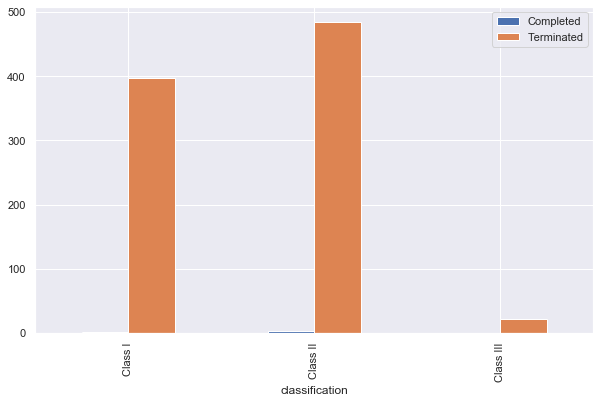

In [67]:
# Checking if Status depend on classification.
#Eg: Checking if all the food items falling under Class 1 degree of hazardness are terminated
#da=df[df['status'] == 'Terminated']
bar_charts(df,'status')

#From the below graph we could say that all food items with highest degree of hazardness are not terminated.


In [68]:
# Create Time Group for the time taken to report  an recalled food item
#Any time taken for more than 4 years is considered as 5 

def Recall_time_group(x):
    if x <= pd.Timedelta(365,'D'):
        Recall_Time = 1
    elif x > pd.Timedelta(365,'D') and x <= pd.Timedelta(730,'D'):
        Recall_Time = 2
    elif x > pd.Timedelta(730,'D') and x <= pd.Timedelta(1095,'D'):
        Recall_Time = 3
    elif x > pd.Timedelta(1095,'D') and x <= pd.Timedelta(1460,'D'):
        Recall_Time = 4
    else:
        Recall_Time = 5
    return Recall_Time
    

In [69]:
df['Recall_Time'] = df['Recall_Time_Taken'].apply(Recall_time_group)

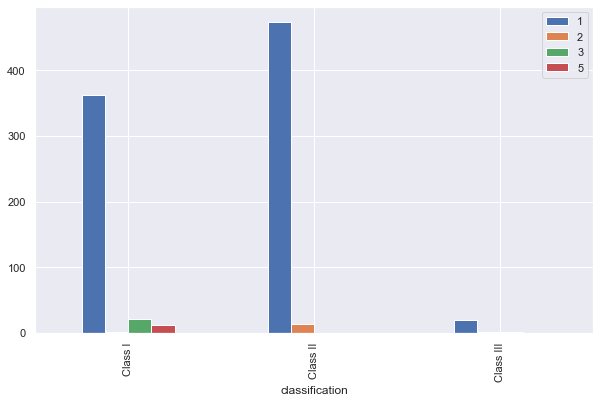

In [70]:
#Checking if the time taken for reporting a food item with issue depends on the class
bar_charts(df,'Recall_Time')
#From the graph below it shows that most of the food items are reported in a year 
#Also there are food items with issues classified as class 1 , but have still taken more than 4 years to report after recalling

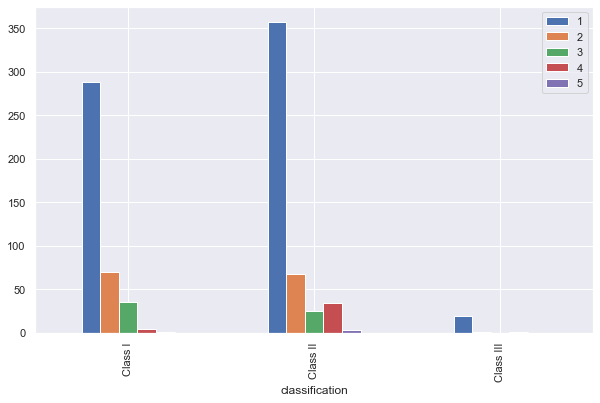

In [71]:
# Are the Class 1 items terminated soner compared to other classes.
df['Terminate_Time'] = df['Terminate_Time_Taken'].apply(Recall_time_group)
bar_charts(df,'Terminate_Time')

#Below graph depicts that the time taken for termination doesnt depend on the class
#But most of the items are terminated within an year

In [72]:
H0= 'Class 1 food items are given priority for termination while compared to other classes.'
H1= 'Class 1 food items are not given priority for termination while compared to other classes.'
da=df[df['status'] == 'Terminated']
alpha = 0.05
N = 200
Class1_Food = da[da['classification'] =='Class I']['Terminate_Time_Taken'].sample(N)
Other_Food = da[da['classification'] != 'Class I']['Terminate_Time_Taken'].sample(N)


In [73]:
#ax = sns.distplot(Class1_Food, label='Class 1 Hazard level', kde=False);
#sns.distplot(Class1_Food, ax=ax, label='Other Hazard Levels', kde=False);
#sns.distplot(Class1_Food, hist=True, color='blue');
#plt.hist(Class1_Food)


In [91]:
var_Class1_Food = Class1_Food.dt.days.var()
print('Class1_Food Variance:',var_Class1_Food)
var_Other_Food = Other_Food.dt.days.var()
print('Other_Food Variance:',var_Other_Food)
np.var(Class1_Food, ddof=1)
std = np.sqrt((var_Class1_Food + var_Other_Food) / 2)
print('std dev:', std)
t = (Other_Food.dt.days.mean() - Class1_Food.dt.days.mean()) / (std * np.sqrt(2 / N))  # t-statistic
print('t:', t)
degf = 2 * N - 2
p = 1 - stats.t.cdf(abs(t), df=degf)  # #p-value after comparison with the t 
p_val=2*p
print("p = " + str(2 * p))
if p_val < alpha:
        print("We reject our null hypothesis.\n")
        print(H1)
elif p_val > alpha:
        print("We fail to reject our null hypothesis.\n")
        print(H0)
else:
        print("Our test is inconclusive.")

Class1_Food Variance: 86906.44922110556
Other_Food Variance: 122627.83919597972
std dev: 323.67753120743896
t: 2.3898785841401087
p = 0.017318418221250464
We reject our null hypothesis.

Class 1 food items are not given priority for termination while compared to other classes.
